# Demographic Relationship with Budget Allocation
2021 census data used to determine if it affects budget allocation of 2022.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
# Add budget into dataframe
capital_budget = Path("Resources/2022-2031-capital-budget-and-plan-details.xlsx")
capital_budget_df = pd.read_excel(capital_budget, sheet_name = "2022-2031")

# loop through columns and clean up names
clean_column_names = [str(col).strip() for col in capital_budget_df.columns]
capital_budget_df.columns = clean_column_names

print(capital_budget_df.columns)

Index(['Program/Agency Name', 'Project Name', 'Sub-Project Name', '2022',
       '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031',
       'Total 10 Year', 'Ward Number', 'Ward', 'Category'],
      dtype='object')


In [3]:
# Find and put unique ward names into list for future looping for profile data
ward_list = list(capital_budget_df["Ward"].unique())
# Removing citywide from ward_list as it does not concern profile data
ward_list.remove("City Wide")  
# Removing extra spaces
ward_list = [ward.strip() for ward in ward_list]
print(ward_list)

['York Centre', 'Spadina-Fort York', 'Toronto Centre', 'Scarborough-Agincourt', 'Scarborough Centre', 'Eglinton-Lawrence', 'York South-Weston', 'Scarborough-Rouge Park', 'Scarborough-North', 'Humber River-Black Creek', 'Davenport', 'Etobicoke North', 'Parkdale-High Park', 'Scarborough Southwest', 'Etobicoke-Lakeshore', 'Toronto-Danforth', 'Toronto-St. Pauls', 'Don Valley West', 'Scarborough-Guildwood', 'Beaches-East York', 'Don Valley North', 'University-Rosedale', 'Willowdale', 'Don Valley East', 'Etobicoke Centre']


In [4]:
# Add up 2022 sum
ward_sum_2022 = capital_budget_df.groupby("Ward")["2022"].sum().reset_index()
# New dataframe with clean summed values
clean_budget_df = pd.DataFrame({"Ward": ward_sum_2022["Ward"], "2022 Budget": ward_sum_2022["2022"]})
# Remove leading and trailing spaces from the "Ward" column in clean_budget_df
clean_budget_df["Ward"] = clean_budget_df["Ward"].str.strip()
print(ward_list)
clean_budget_df

['York Centre', 'Spadina-Fort York', 'Toronto Centre', 'Scarborough-Agincourt', 'Scarborough Centre', 'Eglinton-Lawrence', 'York South-Weston', 'Scarborough-Rouge Park', 'Scarborough-North', 'Humber River-Black Creek', 'Davenport', 'Etobicoke North', 'Parkdale-High Park', 'Scarborough Southwest', 'Etobicoke-Lakeshore', 'Toronto-Danforth', 'Toronto-St. Pauls', 'Don Valley West', 'Scarborough-Guildwood', 'Beaches-East York', 'Don Valley North', 'University-Rosedale', 'Willowdale', 'Don Valley East', 'Etobicoke Centre']


,Ward,2022 Budget
0,Beaches-East York,1137.00
1,City Wide,4230770.88
2,Davenport,8957.00
3,Don Valley East,5190.00
4,Don Valley North,18480.00
5,Don Valley West,1535.00
6,Eglinton-Lawrence,3076.00
7,Etobicoke Centre,12213.00
8,Etobicoke North,198.00
9,Etobicoke-Lakeshore,13279.00


In [5]:
# Add census into dataframe

ward_profile = Path("Resources/98-401-X2021010_English_CSV_data.csv")
ward_profile_df = pd.read_csv(ward_profile, encoding="latin-1")

In [6]:
# CHARACTERISTIC_NAME  
# NOTE: Spaces required as there are other lines with the same characteristic names,
#       so if spaces were removed, it would add other lines that are not part of minority data.
#       e.g. "Chinese" would add both the minority data and language data.
income_data_row = ["    Median total income in 2020 among recipients ($)",
                  "    Average total income in 2020 among recipients ($)",
                  ]
population_density = ["Population density per square kilometre"]
minority_data_row = ["    South Asian",
                    "    Chinese",
                    "    Black",
                    "    Filipino",
                    "    Arab",
                    "    Latin American",
                    "    Southeast Asian",
                    "    West Asian",
                    "    Korean",
                    "    Japanese",
                    "    Visible minority, n.i.e.",
                    "    Multiple visible minorities",
                    "  Not a visible minority"
                    ]

In [7]:
# Add wards with slightly different names
ward_mapping = {
    'Scarborough-North': 'Scarborough North',
    "Toronto-St. Pauls": "Toronto-St. Paul's"
}

ward_list = [ward_mapping.get(ward, ward) for ward in ward_list]

print(ward_list)

['York Centre', 'Spadina-Fort York', 'Toronto Centre', 'Scarborough-Agincourt', 'Scarborough Centre', 'Eglinton-Lawrence', 'York South-Weston', 'Scarborough-Rouge Park', 'Scarborough North', 'Humber River-Black Creek', 'Davenport', 'Etobicoke North', 'Parkdale-High Park', 'Scarborough Southwest', 'Etobicoke-Lakeshore', 'Toronto-Danforth', "Toronto-St. Paul's", 'Don Valley West', 'Scarborough-Guildwood', 'Beaches-East York', 'Don Valley North', 'University-Rosedale', 'Willowdale', 'Don Valley East', 'Etobicoke Centre']


In [8]:
# Filter rows based on "GEO_NAME" and clean the names
filtered_profile_df = ward_profile_df[ward_profile_df["GEO_NAME"].str.replace('--', '-') .isin(ward_list)]


# Filter rows based on "CHARACTERISTIC_NAME"
filtered_profile_df = filtered_profile_df[filtered_profile_df["CHARACTERISTIC_NAME"].isin(income_data_row + minority_data_row + population_density)]


# Create a new DataFrame with specific columns
clean_profile_df = filtered_profile_df[["GEO_NAME", "CHARACTERISTIC_NAME", "C1_COUNT_TOTAL"]]


# Move characteristic name to columns, with C1_COUNT_TOTAL as the values
clean_profile_df = clean_profile_df.pivot(index="GEO_NAME", columns="CHARACTERISTIC_NAME", values="C1_COUNT_TOTAL").reset_index()

clean_profile_df["GEO_NAME"] = clean_profile_df["GEO_NAME"].str.replace('--', '-')

# Reverse names of missing wards to match with budget ward names
reverse_ward_mapping = {
    'Scarborough North': 'Scarborough-North',
    "Toronto-St. Paul's": "Toronto-St. Pauls"
}

clean_profile_df["GEO_NAME"] = clean_profile_df["GEO_NAME"].replace(reverse_ward_mapping)

clean_profile_df



CHARACTERISTIC_NAME,GEO_NAME,Arab,Average total income in 2020 among recipients ($),Black,Chinese,Filipino,Japanese,Korean,Latin American,Median total income in 2020 among recipients ($),Multiple visible minorities,South Asian,Southeast Asian,"Visible minority, n.i.e.",West Asian,Not a visible minority,Population density per square kilometre
0,Beaches-East York,720.0,69500.0,8260.0,5635.0,3565.0,635.0,705.0,2225.0,44000.0,2280.0,12290.0,715.0,920.0,1260.0,69280.0,6531.2
1,Davenport,660.0,55550.0,7100.0,5525.0,3150.0,615.0,835.0,6130.0,40400.0,2195.0,4820.0,2450.0,1215.0,525.0,69520.0,8769.1
2,Don Valley East,3600.0,50680.0,9880.0,7240.0,7175.0,680.0,1360.0,2290.0,36400.0,2260.0,17285.0,810.0,1435.0,5520.0,34810.0,4171.8
3,Don Valley North,2800.0,50880.0,5720.0,32915.0,5680.0,620.0,4350.0,2485.0,36800.0,2595.0,15560.0,1360.0,835.0,8945.0,28715.0,4669.6
4,Don Valley West,1550.0,113600.0,3835.0,12420.0,3510.0,525.0,1590.0,2150.0,47600.0,1760.0,13410.0,615.0,750.0,5305.0,53610.0,3386.0
5,Eglinton-Lawrence,695.0,88500.0,6560.0,5525.0,12465.0,405.0,1290.0,4515.0,44000.0,2125.0,4530.0,1675.0,900.0,1570.0,72560.0,5114.3
6,Etobicoke Centre,1130.0,69200.0,8275.0,3625.0,3455.0,475.0,1960.0,4630.0,44400.0,1775.0,7885.0,1360.0,1330.0,1300.0,79995.0,3198.3
7,Etobicoke North,3280.0,39760.0,27635.0,1415.0,5620.0,100.0,540.0,6270.0,32400.0,3195.0,32480.0,2065.0,4130.0,3405.0,24985.0,2428.3
8,Etobicoke-Lakeshore,1810.0,71100.0,8020.0,5570.0,4490.0,760.0,2375.0,4590.0,47600.0,2735.0,10850.0,2085.0,3550.0,1850.0,91245.0,3575.4
9,Humber River-Black Creek,1840.0,37240.0,27375.0,2710.0,8900.0,80.0,530.0,9975.0,31400.0,3525.0,15295.0,11295.0,3575.0,1870.0,24235.0,3645.5


In [9]:
# Merge the two dataframes with GEO_NAME and Ward
merged_df_jt = pd.merge(clean_budget_df, clean_profile_df, left_on="Ward", right_on="GEO_NAME", how="inner")
# Drop GEO_NAME
merged_df_jt = merged_df_jt.drop("GEO_NAME", axis=1)
# Cleaning merged df for better visual
column_order = income_data_row + population_density + minority_data_row
merged_df_jt = merged_df_jt[["Ward", "2022 Budget"]+ column_order]
merged_df_jt

,Ward,2022 Budget,Median total income in 2020 among recipients ($),Average total income in 2020 among recipients ($),Population density per square kilometre,South Asian,Chinese,Black,Filipino,Arab,Latin American,Southeast Asian,West Asian,Korean,Japanese,"Visible minority, n.i.e.",Multiple visible minorities,Not a visible minority
0,Beaches-East York,1137.0,44000.0,69500.0,6531.2,12290.0,5635.0,8260.0,3565.0,720.0,2225.0,715.0,1260.0,705.0,635.0,920.0,2280.0,69280.0
1,Davenport,8957.0,40400.0,55550.0,8769.1,4820.0,5525.0,7100.0,3150.0,660.0,6130.0,2450.0,525.0,835.0,615.0,1215.0,2195.0,69520.0
2,Don Valley East,5190.0,36400.0,50680.0,4171.8,17285.0,7240.0,9880.0,7175.0,3600.0,2290.0,810.0,5520.0,1360.0,680.0,1435.0,2260.0,34810.0
3,Don Valley North,18480.0,36800.0,50880.0,4669.6,15560.0,32915.0,5720.0,5680.0,2800.0,2485.0,1360.0,8945.0,4350.0,620.0,835.0,2595.0,28715.0
4,Don Valley West,1535.0,47600.0,113600.0,3386.0,13410.0,12420.0,3835.0,3510.0,1550.0,2150.0,615.0,5305.0,1590.0,525.0,750.0,1760.0,53610.0
5,Eglinton-Lawrence,3076.0,44000.0,88500.0,5114.3,4530.0,5525.0,6560.0,12465.0,695.0,4515.0,1675.0,1570.0,1290.0,405.0,900.0,2125.0,72560.0
6,Etobicoke Centre,12213.0,44400.0,69200.0,3198.3,7885.0,3625.0,8275.0,3455.0,1130.0,4630.0,1360.0,1300.0,1960.0,475.0,1330.0,1775.0,79995.0
7,Etobicoke North,198.0,32400.0,39760.0,2428.3,32480.0,1415.0,27635.0,5620.0,3280.0,6270.0,2065.0,3405.0,540.0,100.0,4130.0,3195.0,24985.0
8,Etobicoke-Lakeshore,13279.0,47600.0,71100.0,3575.4,10850.0,5570.0,8020.0,4490.0,1810.0,4590.0,2085.0,1850.0,2375.0,760.0,3550.0,2735.0,91245.0
9,Humber River-Black Creek,5511.2,31400.0,37240.0,3645.5,15295.0,2710.0,27375.0,8900.0,1840.0,9975.0,11295.0,1870.0,530.0,80.0,3575.0,3525.0,24235.0


# Graph - Population Density

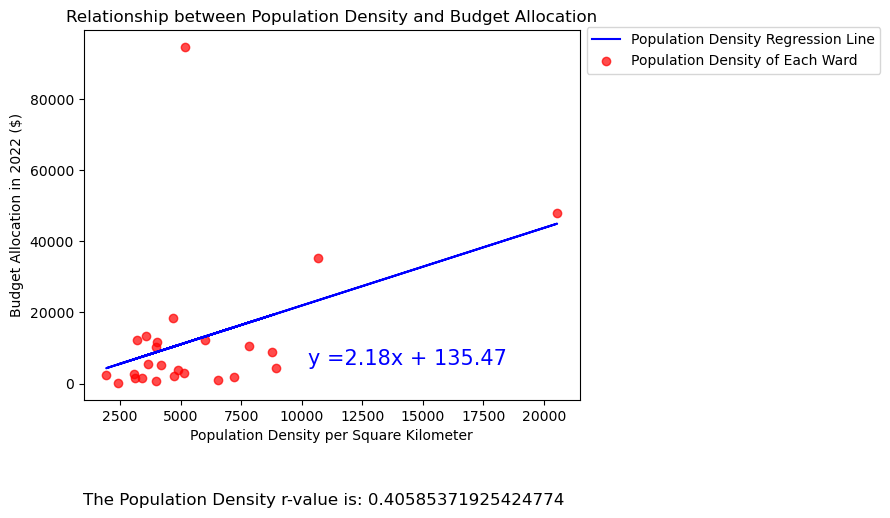

In [10]:
# Extract data for plotting
y_values = merged_df_jt["2022 Budget"]
x_values = merged_df_jt["Population density per square kilometre"]

# Calculate linear regression for Population Density
(slope_density, intercept_density, rvalue_density, pvalue_density, stderr_density) = linregress(x_values, y_values)
regress_density_values = x_values * slope_density + intercept_density
line_eq_density = "y =" + str(round(slope_density, 2)) + "x + " + str(round(intercept_density, 2))
r_value_text = f"The Population Density r-value is: {rvalue_density}"
plt.text(0.5, -0.1, r_value_text, transform=plt.gcf().transFigure, ha='center', va='center', fontsize=12)

plt.plot(x_values, regress_density_values, color='b', label='Population Density Regression Line')
plt.annotate(line_eq_density, xy=(x_values.max() / 2, y_values.min() + 5000), fontsize=15, color="b")
plt.scatter(x_values, y_values, color='red', alpha=0.7, label='Population Density of Each Ward')

# Set labels and title
plt.xlabel('Population Density per Square Kilometer')
plt.ylabel('Budget Allocation in 2022 ($)')
plt.title('Relationship between Population Density and Budget Allocation')

# Display the legend outside to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), bbox_transform=plt.gcf().transFigure)

plt.savefig("output/Demographic/Population Density vs Budget Allocation", bbox_inches='tight')
plt.show()

# Graph - Minority Relationship

combined graph with the x-axis as names in the ward column, with a bar graph showing the combined amount of values in column names in minority_data_row list, and a line graph showing each ward's 2022 budget value

C:\Users\jason\AppData\Local\Temp\ipykernel_32616\880704902.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_colors = plt.cm.get_cmap('prism', len(bar_columns))


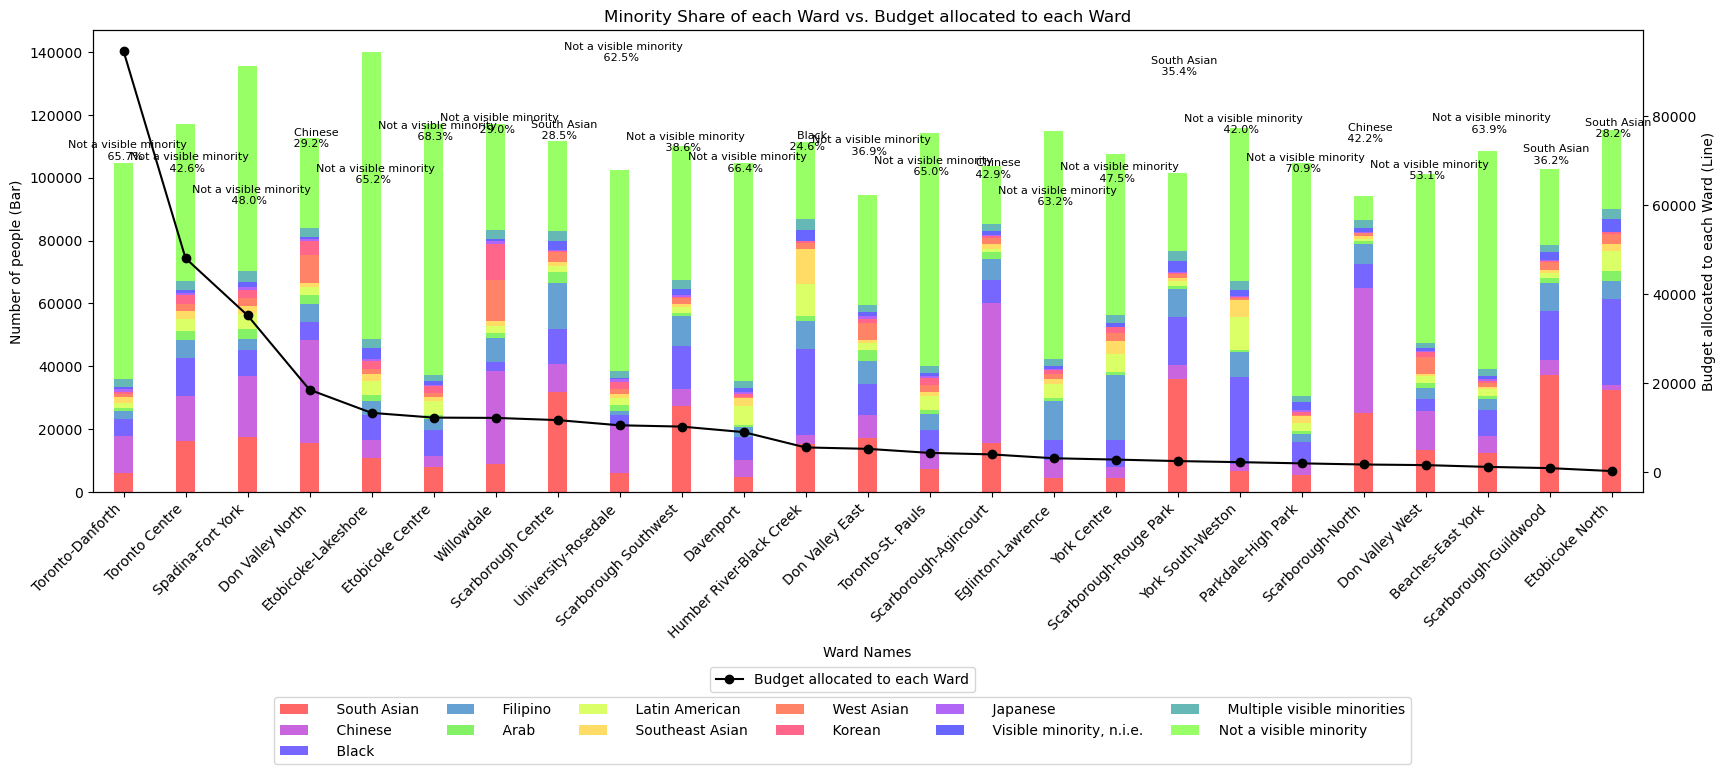

In [11]:
# Sort the DataFrame by 2022 Budget in descending order
merged_df_jt_sorted = merged_df_jt.sort_values(by='2022 Budget', ascending=False)

# Extract data for plotting
ward_names = merged_df_jt_sorted["Ward"]
budget_values = merged_df_jt_sorted["2022 Budget"]

# Columns to include in the bar graph
bar_columns = minority_data_row

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))  

# Get a list of distinct colors for each column
bar_colors = plt.cm.get_cmap('prism', len(bar_columns))

# Stacked Bar graph for minority data
bar_width = 0.3
bar_positions = np.arange(len(ward_names))
bottom_positions = np.zeros(len(ward_names)) #add zeros to bottom_positions(for next bar to be put on top) list to be replaced with bar values.
for i, column in enumerate(bar_columns):
    # Use bottom positions to stack the bars
    bar = ax1.bar(bar_positions, merged_df_jt_sorted[column], bar_width, label=column, color=bar_colors(i), alpha=0.6, bottom=bottom_positions)
    bottom_positions += merged_df_jt_sorted[column]

# Calculate percentage for each bar
total_percentage = pd.DataFrame({column: merged_df_jt_sorted[column] / bottom_positions * 100 for column in bar_columns})

# Find the column with the highest percentage for each ward
highest_percentage_column = total_percentage.idxmax(axis=1)
highest_percentage_value = total_percentage.max(axis=1)

# Annotate bars with the name of the column that has the highest percentage
annotations = []

for index, (column, value) in enumerate(zip(highest_percentage_column, highest_percentage_value)):
    # Find the position for annotation 
    annotation_x = bar_positions[index]
    annotation_y = bottom_positions[index] 
    annotation_text = f"{column}\n {value:.1f}%"
    annotations.append((annotation_x, annotation_y, annotation_text))

# Annotate bars with the name of the column that has the highest total percentage
for x, y, text in annotations:
    ax1.text(x, y, text, ha='center', va='center', rotation=0, color='black', fontsize=8)

# Set up the second axis for the line graph
ax2 = ax1.twinx()
ax2.plot(bar_positions, budget_values, color='black', marker='o', label='Budget allocated to each Ward')

# X-axis labels and ticks
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(ward_names, rotation=45, ha='right')

# Add space on both sides of the x-axis
ax1.set_xlim(bar_positions[0] - 0.5, bar_positions[-1] + 0.5)

# Set labels and title
ax1.set_xlabel('Ward Names')
ax1.set_ylabel('Number of people (Bar)', color='black')
ax2.set_ylabel('Budget allocated to each Ward (Line)', color='black')
plt.title('Minority Share of each Ward vs. Budget allocated to each Ward')

# Display the legend outside to the right of the graph
# Dividing the first legend into two lines

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), bbox_transform=plt.gcf().transFigure, ncol=len(bar_columns)/2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), bbox_transform=plt.gcf().transFigure, ncol=1)

# Save and Show Figure
plt.savefig("output/Demographic/Minority Share vs. Budget.png", bbox_inches='tight')
plt.show()


# Graph - Income Data Relationship
Uses income in 2020 because this would be the data they receive in 2021, to determine 2022 budget.

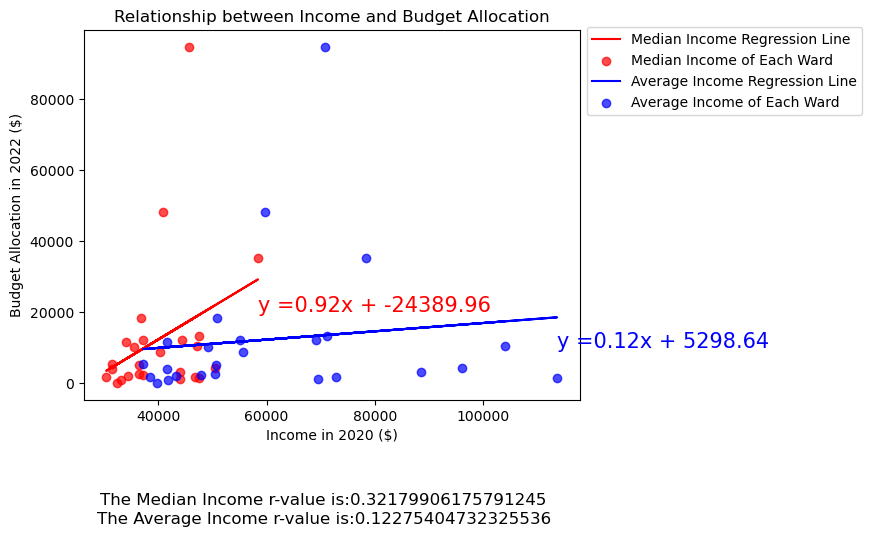

In [12]:
# Extract data for plotting
y_values = merged_df_jt["2022 Budget"]  # Budget allocation
x_median = merged_df_jt["    Median total income in 2020 among recipients ($)"] 
x_average = merged_df_jt["    Average total income in 2020 among recipients ($)"]  

# Calculate linear regression for median income 
(slope_median, intercept_median, rvalue_median, pvalue_median, stderr_median) = linregress(x_median, y_values)
regress_median_values = x_median * slope_median + intercept_median
line_eq_median = "y =" + str(round(slope_median,2)) + "x + " + str(round(intercept_median,2))
r_value_text = f"The Median Income r-value is:{rvalue_median}"
plt.text(0.5, -0.1, r_value_text, transform=plt.gcf().transFigure, ha='center', va='center', fontsize=12)
  
plt.plot(x_median, regress_median_values, color='red', label='Median Income Regression Line')
plt.annotate(line_eq_median, xy=(x_median.max(),y_values.min()+20000), fontsize = 15, color="red")
plt.scatter(x_median, y_values, color='red', alpha=0.7, label='Median Income of Each Ward')


# Calculate linear regression for average income
(slope_average, intercept_average, rvalue_average, pvalue_average, stderr_average) = linregress(x_average, y_values)
regress_average_values = x_average * slope_average + intercept_average
line_eq_average = "y =" + str(round(slope_average,2)) + "x + " + str(round(intercept_average,2))
r_value_text = f"The Average Income r-value is:{rvalue_average}"
plt.text(0.5, -0.14, r_value_text, transform=plt.gcf().transFigure, ha='center', va='center', fontsize=12)
  
plt.plot(x_average, regress_average_values, color='blue', label='Average Income Regression Line')
plt.annotate(line_eq_average, xy=(x_average.max(),y_values.min()+10000), fontsize = 15, color="blue")
plt.scatter(x_average, y_values, color='blue', alpha=0.7, label='Average Income of Each Ward')


# Set labels and title
plt.xlabel('Income in 2020 ($)')
plt.ylabel('Budget Allocation in 2022 ($)')
plt.title('Relationship between Income and Budget Allocation')

# Display the legend outside to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), bbox_transform=plt.gcf().transFigure)

# Save and Show Figure
plt.savefig("output/Demographic/Income vs Budget Allocation", bbox_inches='tight')
plt.show()
